In [5]:
import re
from pathlib import Path
from typing import Dict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def parse_and_plot_matrices(
    *,
    n_features: int,                 # <-- new REQUIRED argument
    file_path: str = "",
    raw_text: str = "",
) -> Dict[int, np.ndarray]:
    """
    Parse projection matrices from the new edge-list log format (and the old
    dense format for backward compatibility) and plot them.

    Parameters
    ----------
    n_features : int   (required)
        Total number of numerical features in the data set.  Every matrix will
        have exactly this number of columns.
    file_path : str
        Path to the log file.  Ignored if `raw_text` is provided.
    raw_text : str
        The log content as a string.

    Returns
    -------
    dict[int, np.ndarray]
        Mapping  node_id -> (n_projections × n_features) numpy matrix.
    """
    if n_features <= 0:
        raise ValueError("n_features must be a positive integer")

    # ------------------------------------------------------------------ #
    # 1.  Load text                                                      #
    # ------------------------------------------------------------------ #
    text = raw_text if raw_text else Path(file_path).read_text()

    # ------------------------------------------------------------------ #
    # 2.  Parse                                                          #
    # ------------------------------------------------------------------ #
    def parse_matrices(text_: str) -> Dict[int, np.ndarray]:
        matrices: Dict[int, np.ndarray] = {}

        # --- new edge-list blocks --------------------------------------
        node_re = re.compile(
            r"Node\s+(\d+)\s*\|\s*(\d+)\s+projections(.*?)(?=Node\s+\d+\s*\||\Z)",
            re.S,
        )

        for node_id_str, n_proj_str, block in node_re.findall(text_):
            node_id = int(node_id_str)
            n_proj = int(n_proj_str)

            mat = np.zeros((n_proj, n_features), dtype=int)

            for line in block.strip().splitlines():
                tokens = line.strip().split()
                if len(tokens) == 3 and tokens[0].isdigit():
                    p, f, w = map(int, tokens)
                    if not (0 <= f < n_features):
                        raise ValueError(
                            f"Feature index {f} in node {node_id} "
                            f"exceeds n_features-1 = {n_features-1}"
                        )
                    if not (0 <= p < n_proj):
                        raise ValueError(
                            f"Projection index {p} in node {node_id} "
                            f"exceeds n_proj-1 = {n_proj-1}"
                        )
                    mat[p, f] = w

            matrices[node_id] = mat

        # --- old dense "proj…" blocks (optional) -----------------------
        old_re = re.compile(r"Node\s+(\d+)(.*?proj.*?)(?=Node\s+\d+|$)", re.S)
        for node_id_str, block in old_re.findall(text_):
            node_id = int(node_id_str)
            rows = []
            for line in block.splitlines():
                line = line.strip()
                if line.startswith("proj"):
                    values = list(map(int, line.split()[2:]))
                    rows.append(values)

            if rows:
                dense = np.asarray(rows, dtype=int)
                if dense.shape[1] > n_features:
                    raise ValueError(
                        f"Old-format matrix for node {node_id} has "
                        f"{dense.shape[1]} columns, exceeds n_features={n_features}"
                    )
                # pad to n_features on the right
                pad_width = n_features - dense.shape[1]
                if pad_width:
                    dense = np.pad(dense, ((0, 0), (0, pad_width)))
                matrices[node_id] = dense

        return matrices

    matrices = parse_matrices(text)

    # ------------------------------------------------------------------ #
    # 3.  Diagnostics that stay up-front                                 #
    # ------------------------------------------------------------------ #
    if matrices:
        print(f"Using n_features = {n_features}")
        first_shape = next(iter(matrices.values())).shape
        print(f"Example matrix dimensions: {first_shape}")
        print(f"Parsed {len(matrices)} nodes:", list(matrices.keys()))

    # ------------------------------------------------------------------ #
    # 4.  Plotting (now with per-matrix diagnostics)                     #
    # ------------------------------------------------------------------ #
    cmap = ListedColormap(["orange", "white", "green"])
    for node, mat in matrices.items():
        # ------------- diagnostics -----------------
        nonzeros = np.count_nonzero(mat, axis=1)
        print(f"\nNode {node}: average non-zeros / row = {nonzeros.mean():.3f}")
        print("Number of non-zeros in matrix:", nonzeros.sum())
        print("Matrix dimensions: ", mat.shape)

        # ------------- figure with two side-by-side axes -------------
        fig, (ax0, ax1) = plt.subplots(
            1, 2, figsize=(12, 4),  # width, height; tweak to taste
            gridspec_kw={"width_ratios": [3, 2]}  # make heat-map a bit wider
        )

        # ---- left pane: heat-map ------------------------------------
        im = ax0.imshow(mat, aspect="auto", cmap=cmap,
                        interpolation="none", vmin=-1, vmax=1)
        ax0.set_title(f"Node {node}")
        ax0.set_xlabel("feature")
        ax0.set_ylabel("projection")
        ax0.set_xticks(range(n_features))
        ax0.set_yticks(range(mat.shape[0]))

        cbar = fig.colorbar(im, ax=ax0, ticks=[-1, 0, 1])
        cbar.set_label("Projection weight")
        cbar.ax.set_yticklabels(["-1", "0", "1"])

        # ---- right pane: histogram ----------------------------------
        bins = np.arange(9) - 0.5          # 0–8 inclusive, centred on ints
        ax1.hist(nonzeros, bins=bins, color="cornflowerblue", edgecolor="k")
        ax1.set_xticks(range(0, 8))
        ax1.set_xlabel("non-zero count distribution")
        ax1.set_ylabel("count")
        ax1.set_title(f"Distribution of nonzeros. Total nonzeros = {nonzeros.sum()}")

        # ---- final touches & show -----------------------------------
        fig.tight_layout()
        plt.show()
        plt.close(fig)

    return matrices

Using n_features = 2523
Example matrix dimensions: (51, 2523)
Parsed 13 nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Node 0: average non-zeros / row = 1.510
Number of non-zeros in matrix: 77
Matrix dimensions:  (51, 2523)


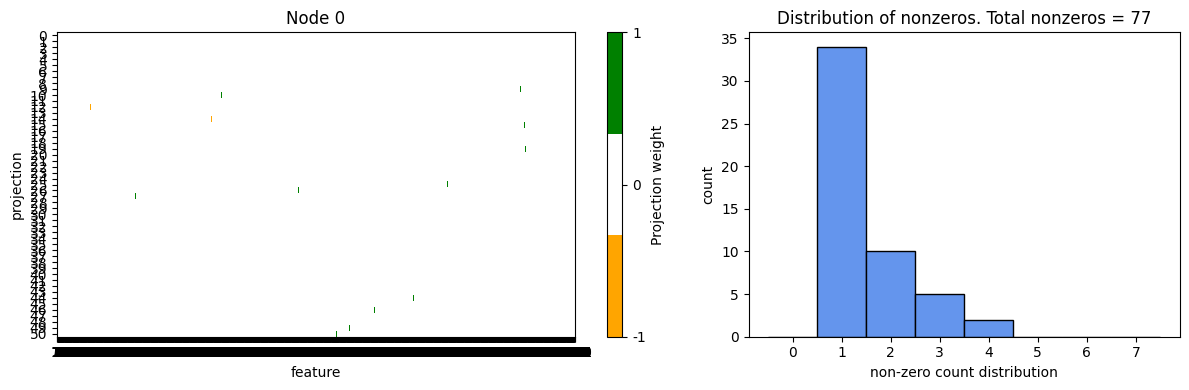


Node 1: average non-zeros / row = 1.627
Number of non-zeros in matrix: 83
Matrix dimensions:  (51, 2523)


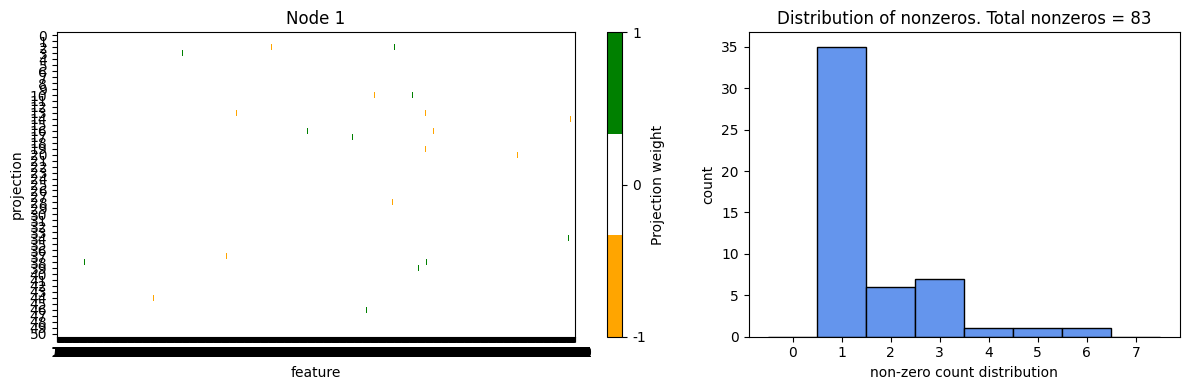


Node 2: average non-zeros / row = 1.745
Number of non-zeros in matrix: 89
Matrix dimensions:  (51, 2523)


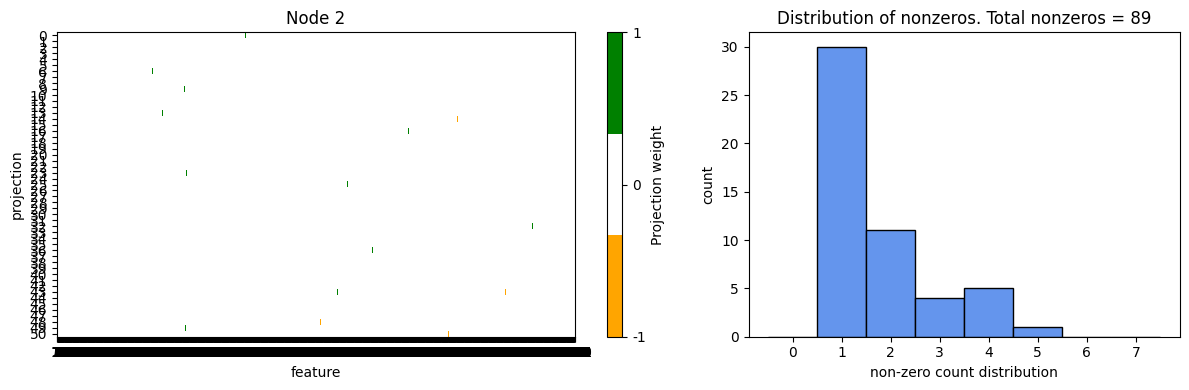


Node 3: average non-zeros / row = 1.784
Number of non-zeros in matrix: 91
Matrix dimensions:  (51, 2523)


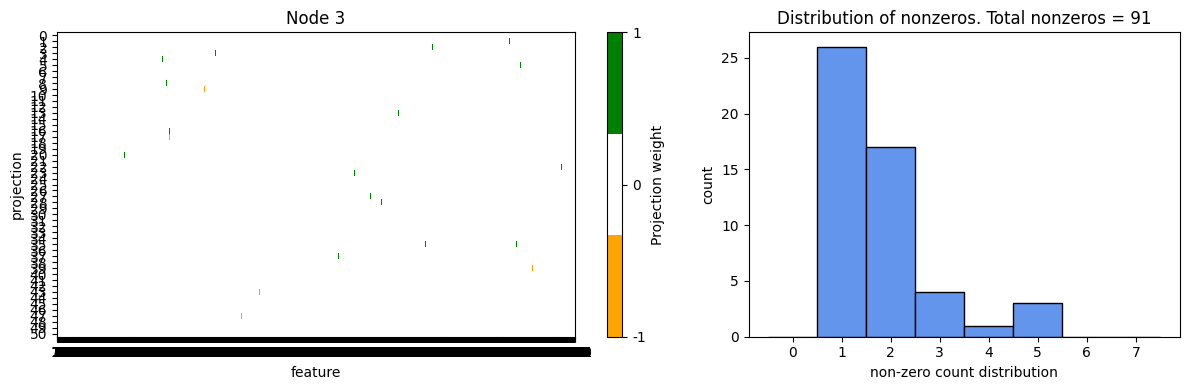


Node 4: average non-zeros / row = 1.922
Number of non-zeros in matrix: 98
Matrix dimensions:  (51, 2523)


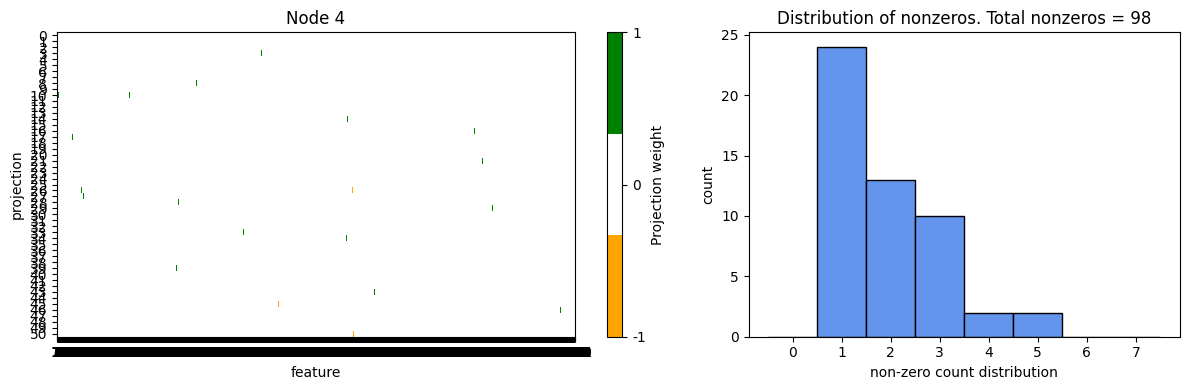


Node 5: average non-zeros / row = 1.529
Number of non-zeros in matrix: 78
Matrix dimensions:  (51, 2523)


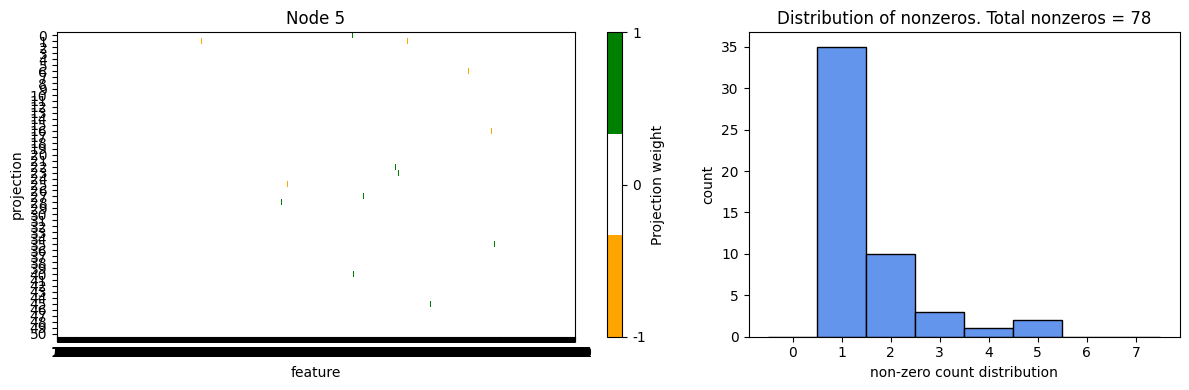


Node 6: average non-zeros / row = 1.804
Number of non-zeros in matrix: 92
Matrix dimensions:  (51, 2523)


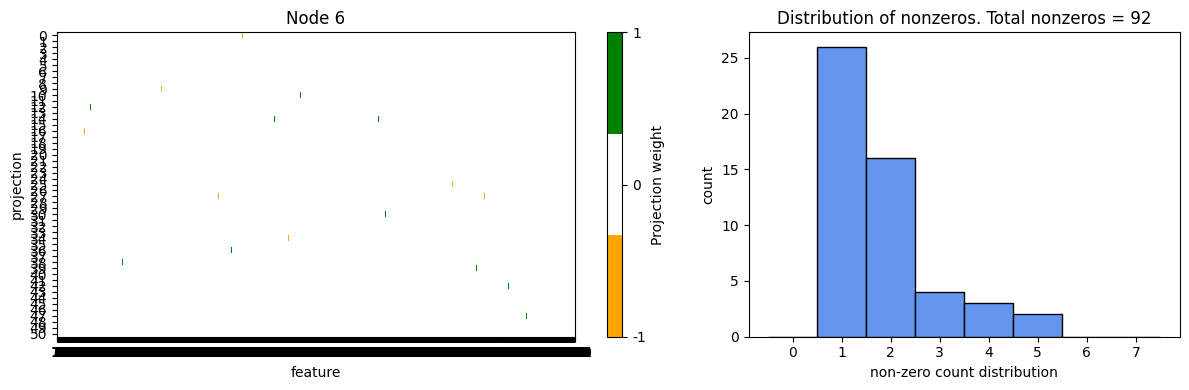


Node 7: average non-zeros / row = 1.667
Number of non-zeros in matrix: 85
Matrix dimensions:  (51, 2523)


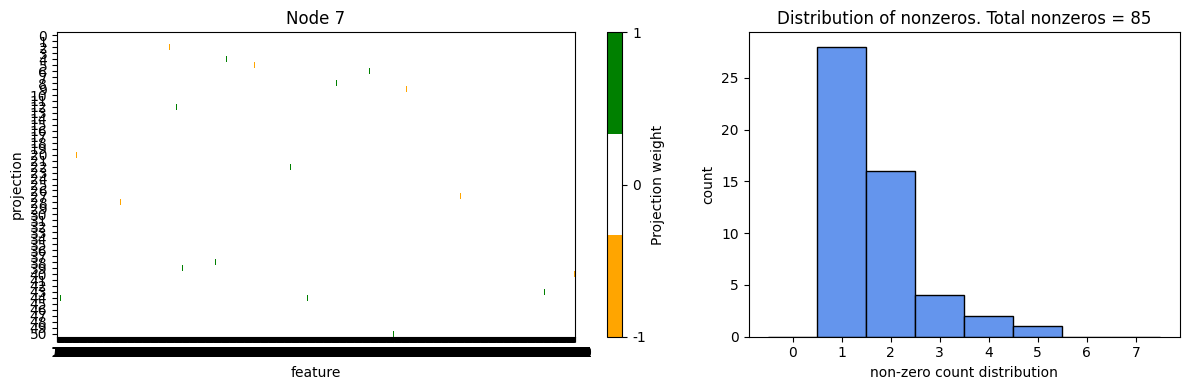


Node 8: average non-zeros / row = 1.627
Number of non-zeros in matrix: 83
Matrix dimensions:  (51, 2523)


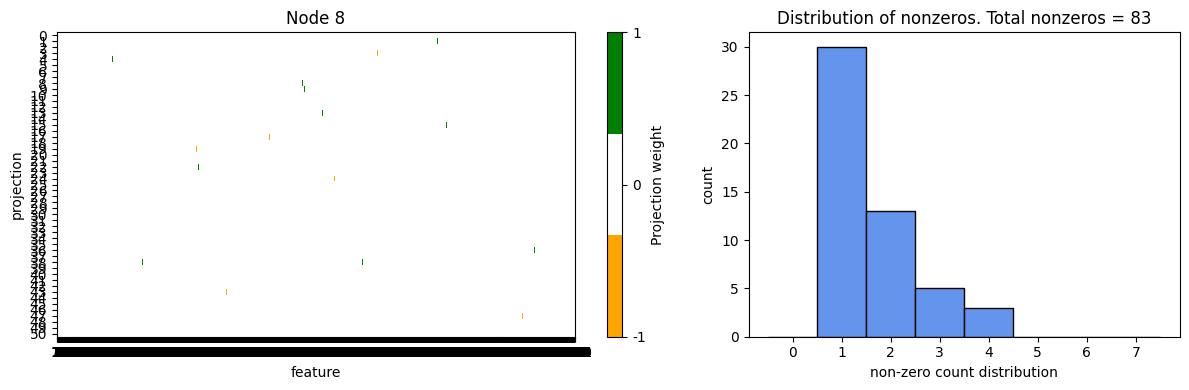


Node 9: average non-zeros / row = 1.824
Number of non-zeros in matrix: 93
Matrix dimensions:  (51, 2523)


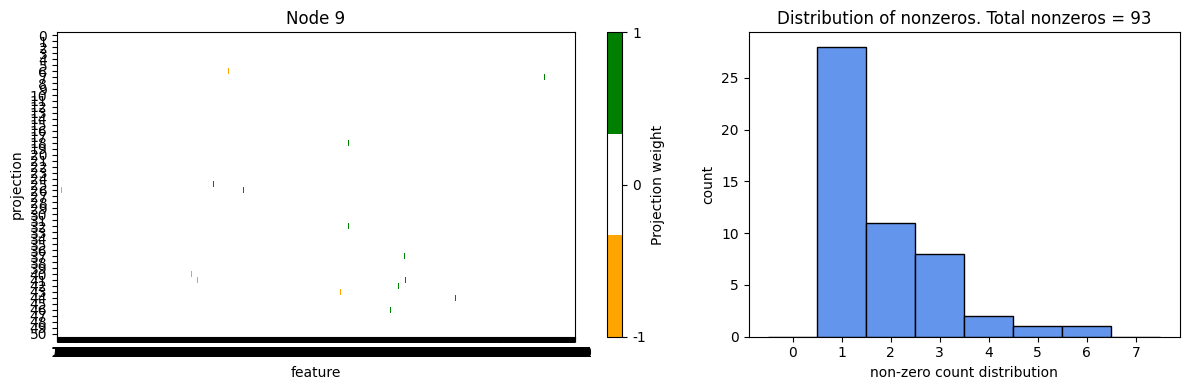


Node 10: average non-zeros / row = 1.686
Number of non-zeros in matrix: 86
Matrix dimensions:  (51, 2523)


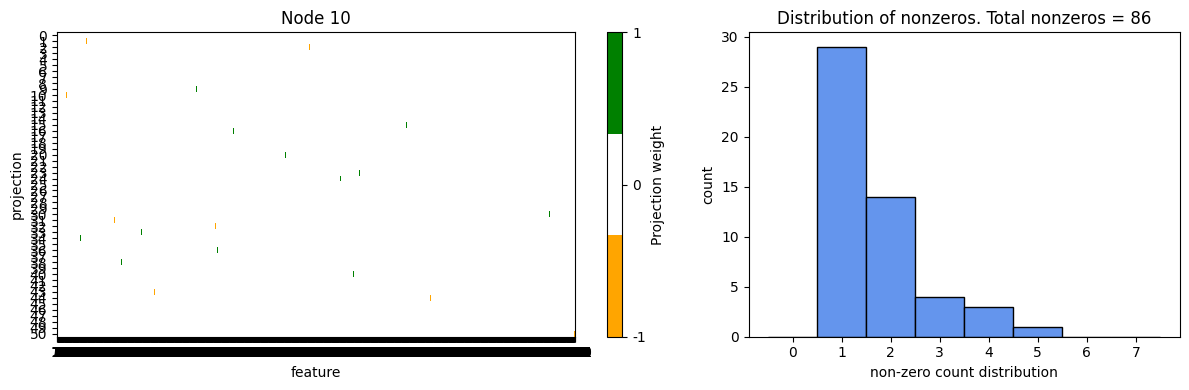


Node 11: average non-zeros / row = 1.725
Number of non-zeros in matrix: 88
Matrix dimensions:  (51, 2523)


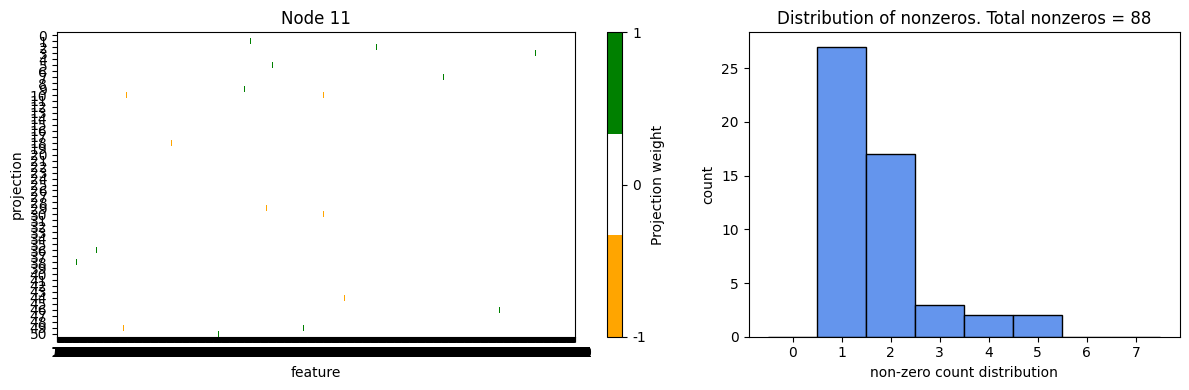


Node 12: average non-zeros / row = 1.627
Number of non-zeros in matrix: 83
Matrix dimensions:  (51, 2523)


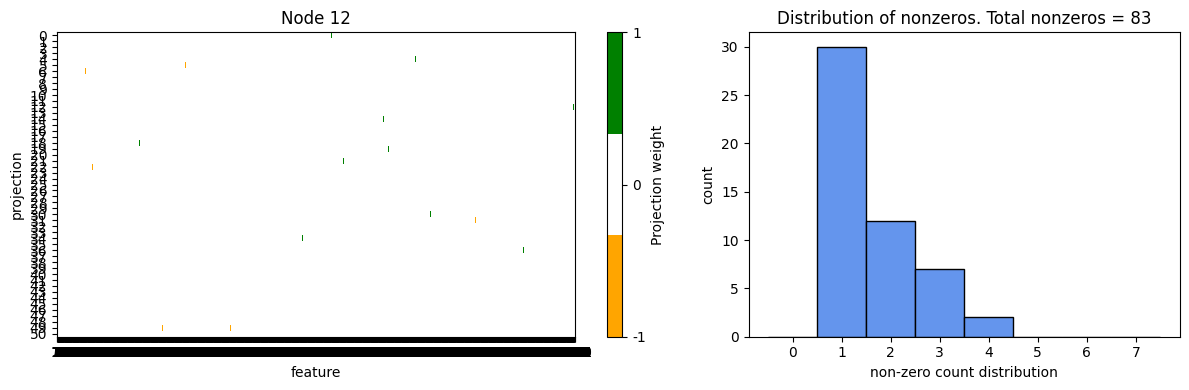

In [6]:
_ = parse_and_plot_matrices(file_path="../results/ydf_projection_matrices/projection_matrices.txt", n_features=2523)

In [19]:
import re
from pathlib import Path
from typing import Dict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def parse_and_plot_matrices(
    *,
    n_features: int,                 # <-- new REQUIRED argument
    file_path: str = "",
    raw_text: str = "",
) -> Dict[int, np.ndarray]:
    """
    Parse projection matrices from the new edge-list log format (and the old
    dense format for backward compatibility) and plot them.

    Parameters
    ----------
    n_features : int   (required)
        Total number of numerical features in the data set.  Every matrix will
        have exactly this number of columns.
    file_path : str
        Path to the log file.  Ignored if `raw_text` is provided.
    raw_text : str
        The log content as a string.

    Returns
    -------
    dict[int, np.ndarray]
        Mapping  node_id -> (n_projections × n_features) numpy matrix.
    """
    if n_features <= 0:
        raise ValueError("n_features must be a positive integer")

    # ------------------------------------------------------------------ #
    # 1.  Load text                                                      #
    # ------------------------------------------------------------------ #
    text = raw_text if raw_text else Path(file_path).read_text()

    # ------------------------------------------------------------------ #
    # 2.  Parse                                                          #
    # ------------------------------------------------------------------ #
    def parse_matrices(text_: str) -> Dict[int, np.ndarray]:
        matrices: Dict[int, np.ndarray] = {}

        # --- new edge-list blocks --------------------------------------
        node_re = re.compile(
            r"Node\s+(\d+)\s*\|\s*(\d+)\s+projections(.*?)(?=Node\s+\d+\s*\||\Z)",
            re.S,
        )

        for node_id_str, n_proj_str, block in node_re.findall(text_):
            node_id = int(node_id_str)
            n_proj = int(n_proj_str)

            mat = np.zeros((n_proj, n_features), dtype=int)

            for line in block.strip().splitlines():
                tokens = line.strip().split()
                if len(tokens) == 3 and tokens[0].isdigit():
                    p, f, w = map(int, tokens)
                    if not (0 <= f < n_features):
                        raise ValueError(
                            f"Feature index {f} in node {node_id} "
                            f"exceeds n_features-1 = {n_features-1}"
                        )
                    if not (0 <= p < n_proj):
                        raise ValueError(
                            f"Projection index {p} in node {node_id} "
                            f"exceeds n_proj-1 = {n_proj-1}"
                        )
                    mat[p, f] = w

            matrices[node_id] = mat

        # --- old dense "proj…" blocks (optional) -----------------------
        old_re = re.compile(r"Node\s+(\d+)(.*?proj.*?)(?=Node\s+\d+|$)", re.S)
        for node_id_str, block in old_re.findall(text_):
            node_id = int(node_id_str)
            rows = []
            for line in block.splitlines():
                line = line.strip()
                if line.startswith("proj"):
                    values = list(map(int, line.split()[2:]))
                    rows.append(values)

            if rows:
                dense = np.asarray(rows, dtype=int)
                if dense.shape[1] > n_features:
                    raise ValueError(
                        f"Old-format matrix for node {node_id} has "
                        f"{dense.shape[1]} columns, exceeds n_features={n_features}"
                    )
                # pad to n_features on the right
                pad_width = n_features - dense.shape[1]
                if pad_width:
                    dense = np.pad(dense, ((0, 0), (0, pad_width)))
                matrices[node_id] = dense

        return matrices

    matrices = parse_matrices(text)

    # ------------------------------------------------------------------ #
    # 3.  Diagnostics that stay up-front                                 #
    # ------------------------------------------------------------------ #
    if matrices:
        print(f"Using n_features = {n_features}")
        first_shape = next(iter(matrices.values())).shape
        print(f"Example matrix dimensions: {first_shape}")
        print(f"Parsed {len(matrices)} nodes:", list(matrices.keys()))

    # ------------------------------------------------------------------ #
    # 4.  Plotting (now with per-matrix diagnostics)                     #
    # ------------------------------------------------------------------ #
    cmap = ListedColormap(["orange", "white", "green"])

    for node, mat in matrices.items():
        # --- per-matrix diagnostics -----------------------------------
        nonzeros = np.count_nonzero(mat, axis=1)
        print(f"Node {node}: average non-zeros / row = {nonzeros.mean():.2f}")
        plt.hist(nonzeros.flatten(), range=(0, 8))
        plt.show()
        plt.close()

    return matrices

Using n_features = 2523
Example matrix dimensions: (51, 2523)
Parsed 13 nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Node 0: average non-zeros / row = 1.51


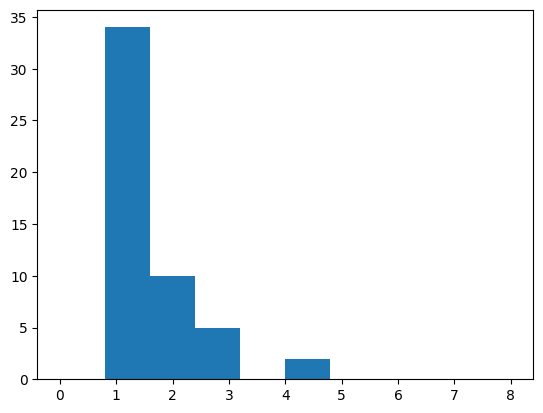

Node 1: average non-zeros / row = 1.63


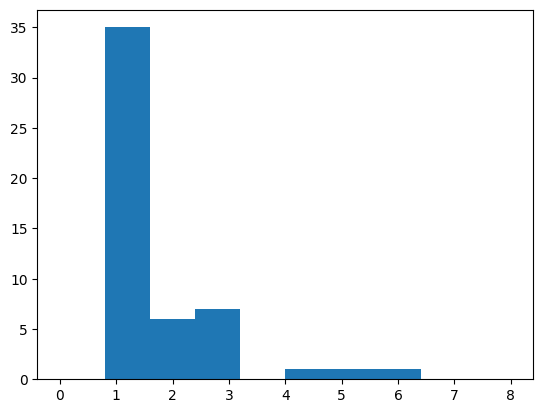

Node 2: average non-zeros / row = 1.75


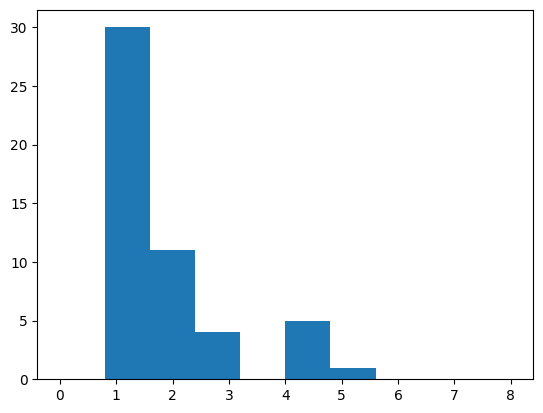

Node 3: average non-zeros / row = 1.78


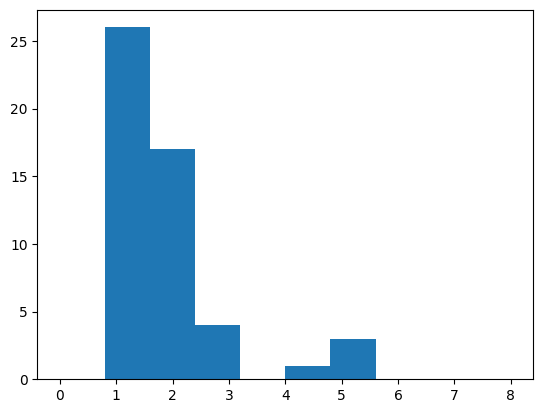

Node 4: average non-zeros / row = 1.92


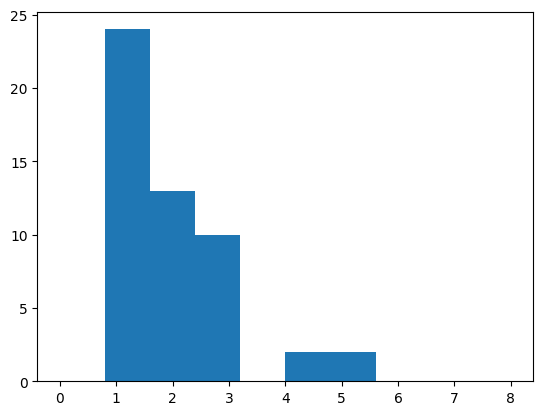

Node 5: average non-zeros / row = 1.53


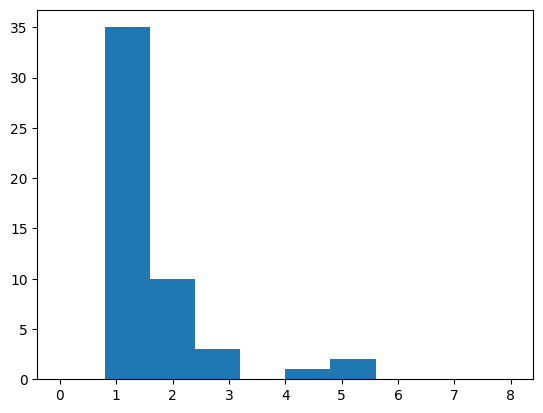

Node 6: average non-zeros / row = 1.80


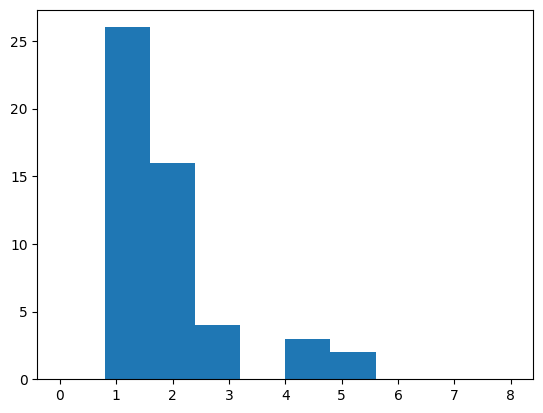

Node 7: average non-zeros / row = 1.67


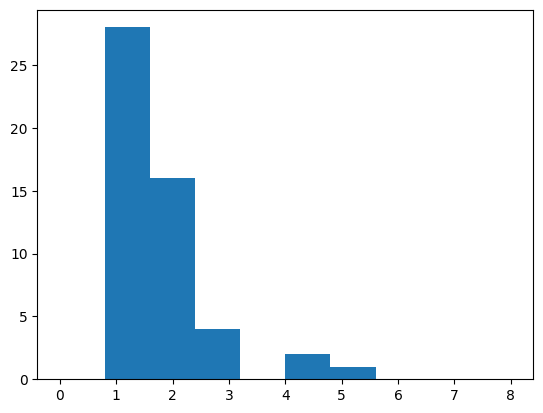

Node 8: average non-zeros / row = 1.63


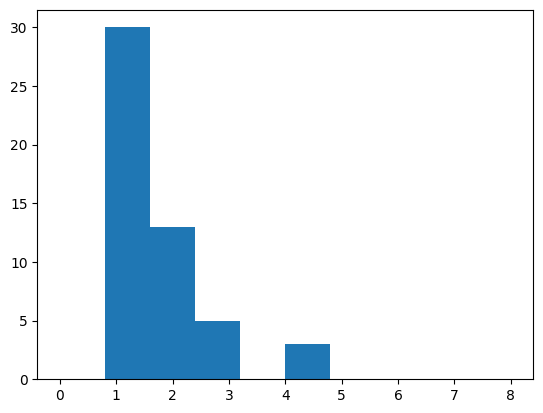

Node 9: average non-zeros / row = 1.82


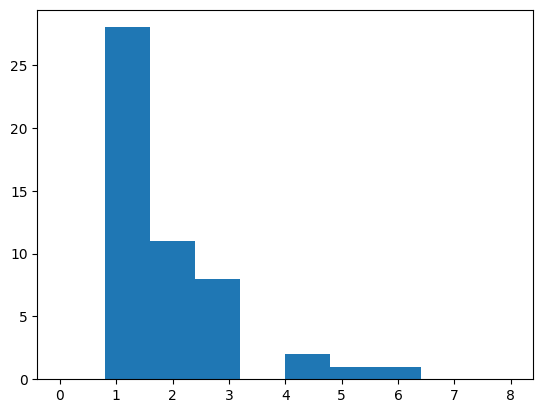

Node 10: average non-zeros / row = 1.69


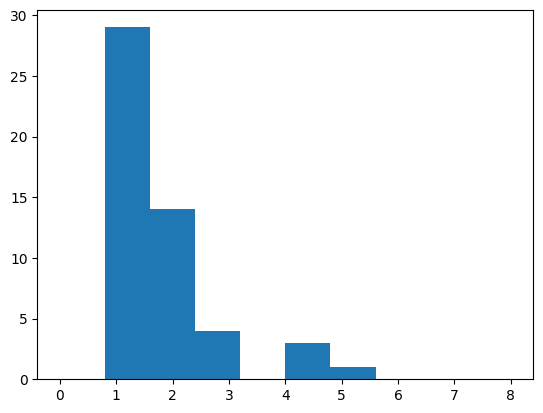

Node 11: average non-zeros / row = 1.73


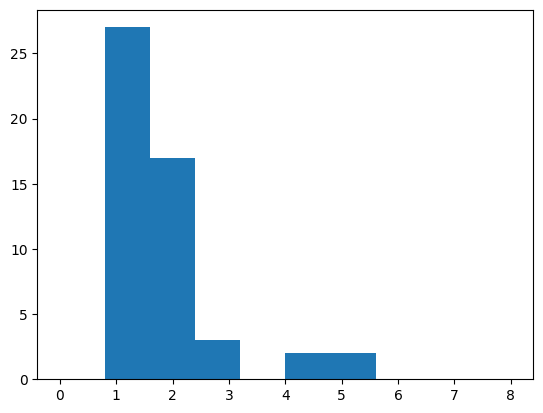

Node 12: average non-zeros / row = 1.63


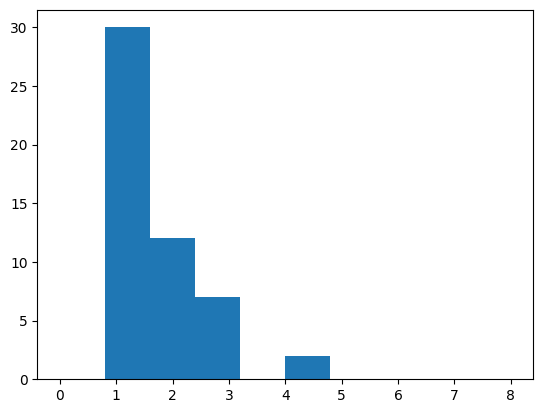

In [20]:
_ = parse_and_plot_matrices(file_path="../results/ydf_projection_matrices/projection_matrices.txt", n_features=2523)